# Preparation

## Import Module

In [1]:
import re
import ast
import pickle
import random
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from functional import seq
from loguru import logger

from scipy.stats import pearsonr
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, RFE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

from gplearn.genetic import SymbolicRegressor
from sympy import sympify

from catboost import CatBoostRegressor, Pool, cv

from matplotlib.font_manager import FontProperties
from matplotlib import rcParams

config = {
            "font.family": "serif",
            "font.size": 12,
            "mathtext.fontset": "stix",# matplotlib渲染数学字体时使用的字体，和Times New Roman差别不大
            "font.serif": ["STZhongsong"],# 华文中宋
            "axes.unicode_minus": False # 处理负号，即-号
         }
rcParams.update(config)

import sys
sys.path.append(".")
sys.path.append("D:\Code\Mine\occupational_health_system_v2")
sys.path.append("D:\Study_and_Work\Mine\之江实验室\PostDoc\\2_课题\Code\Mine\occupational_health_system_v2")
from staff_info import StaffInfo
from utils.data_helper import dcov_all, root_mean_squared_error
from comparasion_between_AC import get_importance_from_regressor, catboost_regressor_params


## Data Loader

In [2]:
extract_df = pd.read_csv("./results/extract_df.csv", header=0, index_col="staff_id")
model_path = Path("./models/")
extract_df.head(1)

label_columns = seq(extract_df.columns).filter(lambda x: x.startswith("NIPTS")).list()
X_ini = extract_df.drop(label_columns, axis=1)
y = extract_df.NIPTS
logger.info(f"X shape: {X_ini.shape}, y shape: {y.shape}")


2024-01-15 15:26:46.529 | INFO     | __main__:<module>:8 - X shape: (194, 91), y shape: (194,)


# Symbolic Resgession Test

In [ ]:
initial_features_search = [
            "LAeq",# "LCeq", "Leq", 
            # "LAeq_adjust_segment_ari_A+A", "LCeq_adjust_segment_ari_C+C",
            # "LAeq_adjust_total_ari_A+A", "LCeq_adjust_total_ari_C+C",
            # "LAeq_adjust_total_geo_A+A", "LCeq_adjust_total_geo_C+C",
            # "max_Peak_SPL_dB",
            "kurtosis_geomean",
        ]
X = extract_df[initial_features_search]
y = extract_df["NIPTS"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = SymbolicRegressor(population_size=1000,
                          generations=500,
                          tournament_size=20,
                          function_set=('add', 'sub', 'mul', 'div', 'sqrt', 'log', 'abs'),
                          metric='rmse',
                          stopping_criteria=0.01,
                          p_crossover=0.7,
                          p_subtree_mutation=0.1,
                          p_hoist_mutation=0.05,
                          p_point_mutation=0.1,
                          verbose=1,
                          n_jobs=-1,
                          random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
MAE = mean_absolute_error(y_test, y_pred)
RMSE = root_mean_squared_error(y_test, y_pred)
logger.info(f"MAE = {MAE}, RMSE = {RMSE}")


In [5]:
print("Best equation:", model._program)
# expression = sympify(str(model._program))
# print("Mathematical expression: ", expression)

Best equation: add(mul(sqrt(-0.101), mul(X0, 0.444)), sqrt(add(log(div(div(sub(X1, -0.305), X1), mul(X1, X0))), sub(sub(X1, -0.951), -0.801))))


In [3]:
import physo

initial_features_search = [
            "LAeq",# "LCeq", "Leq", 
            # "LAeq_adjust_segment_ari_A+A", "LCeq_adjust_segment_ari_C+C",
            # "LAeq_adjust_total_ari_A+A", "LCeq_adjust_total_ari_C+C",
            # "LAeq_adjust_total_geo_A+A", "LCeq_adjust_total_geo_C+C",
            # "max_Peak_SPL_dB",
            "kurtosis_geomean",
        ]
X = extract_df[initial_features_search]
y = extract_df["NIPTS"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# expression, logs = physo.SR(X_train.T.values, y_train.values,
#                             X_names = ["L", "b"],
#                             # X_units = [ [1, 0, 0] , [1, -1, 0] ],
#                             y_name  = "NIPTS",
#                             # y_units = [2, -2, 1],
#                             fixed_consts       = [ 1.      ],
#                             # fixed_consts_units = [ [0,0,0] ],
#                             free_consts_names = [ "lambda"],
#                             # free_consts_units = [ [0, 0, 1] , [1, -2, 0] ],
#                             op_names = ["mul", "add", "sub", "div", "inv", "n2", "sqrt", "neg", "exp", "log", "sin", "cos"],
#                             run_config=physo.config.config1.config1
# )

Parallel mode is not available because physo is being ran from a notebook on a system returning multiprocessing.get_start_method() = 'spawn' (typically MACs/Windows). Run physo from the terminal to use parallel mode.
Parallel mode is not available because physo is being ran from a notebook on a system returning multiprocessing.get_start_method() = 'spawn' (typically MACs/Windows). Run physo from the terminal to use parallel mode.

default get_start_method : spawn
Running from notebook : True
Is CUDA available : False
Total nb. of CPUs :  20
Recommended config {'parallel_mode': False, 'n_cpus': 20}
Parallel mode is not available because physo is being ran from a notebook on a system returning multiprocessing.get_start_method() = 'spawn' (typically MACs/Windows). Run physo from the terminal to use parallel mode.
Parallel mode is not available because physo is being ran from a notebook on a system returning multiprocessing.get_start_method() = 'spawn' (typically MACs/Windows). Run physo f

d:\code\github\wassimtenachi-physo-8b0094e\physo\physym\program.py:20: UserWarning: Can not import display packages.
  warnings.warn("Can not import display packages.")
d:\code\github\wassimtenachi-physo-8b0094e\physo\physym\execute.py:182: UserWarning: Parallel mode is not available because physo is being ran from a notebook on a system returning multiprocessing.get_start_method() = 'spawn' (typically MACs/Windows). Run physo from the terminal to use parallel mode.
  warnings.warn(msg)
d:\code\github\wassimtenachi-physo-8b0094e\physo\physym\reward.py:229: UserWarning: Parallel mode is not available on this system, switching to non parallel mode.
  warnings.warn("Parallel mode is not available on this system, switching to non parallel mode.")


In [4]:
def plot_pareto_front(run_logger,
                      do_simplify                   = True,
                      show_superparent_at_beginning = True,
                      eq_text_size                  = 18,
                      delta_xlim                    = [0, 5 ],
                      delta_ylim                    = [-0.1, 0.005],
                      frac_delta_equ                = [0.01, -0.01],
                      figsize                       = (20, 10),
                     ):

    pareto_front_complexities, pareto_front_programs, pareto_front_r, pareto_front_rmse = run_logger.get_pareto_front()

    pareto_front_r2 = physo.physym.reward.SquashedNRMSE_to_R2(pareto_front_r)
    # Fig params
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    # enables new_dummy_symbol = "\square"
    plt.rc('text.latex', preamble=r'\usepackage{amssymb} \usepackage{xcolor}')

    # Fig
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.plot(pareto_front_complexities, pareto_front_r2, 'r-')
    ax.plot(pareto_front_complexities, pareto_front_r2, 'ro')

    # Limits
    xmin = pareto_front_complexities.min() + delta_xlim[0]
    xmax = pareto_front_complexities.max() + delta_xlim[1]
    ymin = pareto_front_r2.min() + delta_ylim[0]
    ymax = pareto_front_r2.max() + delta_ylim[1]
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.invert_yaxis()

    # Axes labels
    ax.set_xlabel("Expression complexity")
    ax.set_ylabel("$R^2$")


    for i_prog in range (len(pareto_front_programs)):
        prog = pareto_front_programs[i_prog]

        text_pos  = [pareto_front_complexities[i_prog] + frac_delta_equ[0]*(xmax-xmin), 
                     pareto_front_r2[i_prog]         + frac_delta_equ[1]*(ymax-ymin)]
        # Getting latex expr
        latex_str = prog.get_infix_latex(do_simplify = do_simplify)
        # Adding "superparent =" before program to make it pretty
        if show_superparent_at_beginning:
            latex_str = prog.library.superparent.name + ' =' + latex_str


        ax.annotate(text = f'${latex_str}$',
                    xy   = (text_pos[0], text_pos[1]), 
                    size = eq_text_size,
                    ha   = "left",
                    va   = "bottom",
                   )
    return fig


In [5]:
from physo.learn import monitoring
from physo.task  import benchmark
save_path_training_curves = 'SR_curves.png'
save_path_log             = 'SR.log'

run_logger     = monitoring.RunLogger(save_path = save_path_log, 
                                      do_save = True)

run_visualiser = monitoring.RunVisualiser (epoch_refresh_rate = 5,
                                           save_path = save_path_training_curves,
                                           do_show   = False,
                                           do_prints = True,
                                           do_save   = True, )

In [8]:
pareto_front_complexities, pareto_front_programs, pareto_front_r, pareto_front_rmse = run_logger.get_pareto_front()

AttributeError: 'RunLogger' object has no attribute 'pareto_rewards'

In [6]:
plot_pareto_front(run_logger)

AttributeError: 'RunLogger' object has no attribute 'pareto_rewards'

In [14]:
X_train.T.values.shape

(2, 155)

# Feature Engineering
## Feature filter

### Pearson coefficient

* Select features whose absolute pearson coefficient with NIPTS value is larger than 0.1(average value)

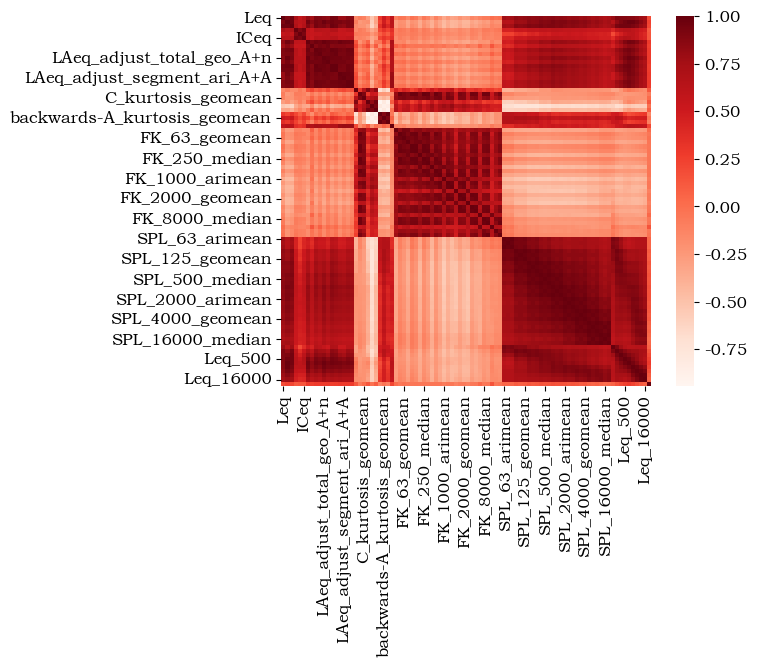

In [3]:
corr_matrix = X_ini.join(y).corr()
sns.heatmap(corr_matrix,annot = False,vmax = 1,square = True,cmap = "Reds")
plt.show()

In [4]:
corr_matrix["NIPTS"].abs().describe()

count    92.000000
mean      0.129983
std       0.123746
min       0.012239
25%       0.050695
50%       0.107256
75%       0.157894
max       1.000000
Name: NIPTS, dtype: float64

In [5]:
pearson_filter_features = seq(
    corr_matrix[np.abs(corr_matrix["NIPTS"]) > 0.1].index).filter(
        lambda x: not x.startswith("NIPTS")).list()
len(pearson_filter_features)

47

### Distance correction coefficient

* Select features whose distance correction coefficient with NIPTS value is larger than 0.02 (average value)

In [6]:
dcors = {}
for col in X_ini.columns:
    dcors[col] = dcov_all(X_ini[col].values, y.values)
pd.Series(dcors).describe()

count    91.000000
mean      0.028631
std       0.019451
min       0.007708
25%       0.014261
50%       0.020606
75%       0.036156
max       0.073376
dtype: float64

In [7]:
cdors_filter_features = seq(
    dcors.items()).filter(lambda x: x[1] > 0.02).map(lambda x: x[0]).list()
len(cdors_filter_features)

47

### Final filter

* Select features both in pearson filter and distance filter

In [8]:
final_filter_features = set(pearson_filter_features) & set(cdors_filter_features)
len(final_filter_features)

43

In [9]:
X_filter = X_ini[list(final_filter_features)].copy()
X_filter.shape

(194, 43)

## Feature Wrapper

* Wrapper will left half of the features.

In [10]:
wrapper = RFE(estimator=RandomForestRegressor(), n_features_to_select=X_filter.shape[1]//2)
wrapper = wrapper.fit(X_filter, y)
final_wrapper_features = X_filter.columns[wrapper.support_]

In [13]:
final_wrapper_features

Index(['LCeq_adjust_total_geo_C+C', 'kurtosis_geomean', 'Leq_4000', 'Ieq',
       'FK_2000_arimean', 'max_Peak_SPL_dB', 'Leq_2000', 'SPL_2000_median',
       'LAeq_adjust_segment_ari_A+n', 'LAeq_adjust_total_ari_A+n', 'Leq_500',
       'LCeq_adjust_segment_ari_C+n', 'log-kurtosis_geomean',
       'SPL_250_geomean', 'SPL_4000_geomean', 'Leq_1000', 'Leq_250',
       'FK_16000_arimean', 'Leq_8000', 'SPL_2000_arimean',
       'LCeq_adjust_segment_ari_C+C'],
      dtype='object')

In [12]:
X_wrapper = X_ini[final_wrapper_features].copy()
X_wrapper.shape

(194, 21)

## Feature combination

* combination features with degree=2
* filter features by above workflows to reduce feature number

In [15]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_combination = pd.DataFrame(poly.fit_transform(X_wrapper), columns=poly.get_feature_names_out(), index=X_wrapper.index)
X_combination.shape

(194, 252)

### Feature selection again
#### Feature filter

In [16]:
corr_matrix = X_combination.join(y).corr()
corr_matrix["NIPTS"].abs().describe()

count    253.000000
mean       0.186372
std        0.079673
min        0.006683
25%        0.135488
50%        0.177645
75%        0.228447
max        1.000000
Name: NIPTS, dtype: float64

In [18]:
sub_pearson_filter_features = seq(
    corr_matrix[np.abs(corr_matrix["NIPTS"]) > 0.15].index).filter(
        lambda x: not x.startswith("NIPTS")).list()
len(sub_pearson_filter_features)

175

In [19]:
dcors = {}
for col in X_combination.columns:
    dcors[col] = dcov_all(X_combination[col].values, y.values)
pd.Series(dcors).describe()

count    252.000000
mean       0.040747
std        0.016047
min        0.011447
25%        0.029959
50%        0.036267
75%        0.049594
max        0.074614
dtype: float64

In [20]:
sub_cdors_filter_features = seq(
    dcors.items()).filter(lambda x: x[1] > 0.04).map(lambda x: x[0]).list()
len(sub_cdors_filter_features)

104

In [21]:
sub_final_filter_features = set(sub_pearson_filter_features) & set(sub_cdors_filter_features)
len(sub_final_filter_features)

104

In [64]:
sub_final_filter_features

{'Ieq FK_16000_arimean',
 'LAeq_adjust_segment_ari_A+n',
 'LAeq_adjust_segment_ari_A+n LAeq_adjust_total_ari_A+n',
 'LAeq_adjust_segment_ari_A+n LCeq_adjust_segment_ari_C+C',
 'LAeq_adjust_segment_ari_A+n LCeq_adjust_segment_ari_C+n',
 'LAeq_adjust_segment_ari_A+n Leq_1000',
 'LAeq_adjust_segment_ari_A+n Leq_250',
 'LAeq_adjust_segment_ari_A+n Leq_500',
 'LAeq_adjust_segment_ari_A+n SPL_2000_arimean',
 'LAeq_adjust_segment_ari_A+n SPL_250_geomean',
 'LAeq_adjust_segment_ari_A+n log-kurtosis_geomean',
 'LAeq_adjust_segment_ari_A+n^2',
 'LAeq_adjust_total_ari_A+n',
 'LAeq_adjust_total_ari_A+n LCeq_adjust_segment_ari_C+C',
 'LAeq_adjust_total_ari_A+n LCeq_adjust_segment_ari_C+n',
 'LAeq_adjust_total_ari_A+n Leq_1000',
 'LAeq_adjust_total_ari_A+n Leq_250',
 'LAeq_adjust_total_ari_A+n Leq_500',
 'LAeq_adjust_total_ari_A+n SPL_2000_arimean',
 'LAeq_adjust_total_ari_A+n SPL_250_geomean',
 'LAeq_adjust_total_ari_A+n log-kurtosis_geomean',
 'LAeq_adjust_total_ari_A+n^2',
 'LCeq_adjust_segment_a

In [35]:
X_combination_filter = X_combination[list(sub_final_filter_features)].copy()
X_combination_filter.shape

(194, 104)

#### Feature wrapper

In [43]:
subwrapper = RFE(estimator=RandomForestRegressor(), n_features_to_select=X_combination_filter.shape[1]//2)
subwrapper = subwrapper.fit(X_combination_filter, y)
sub_final_wrapper_features = X_combination_filter.columns[subwrapper.support_]

In [63]:
sub_final_wrapper_features

Index(['LAeq_adjust_total_ari_A+n Leq_500',
       'LAeq_adjust_segment_ari_A+n SPL_2000_arimean',
       'log-kurtosis_geomean SPL_2000_arimean',
       'LAeq_adjust_total_ari_A+n Leq_250', 'Leq_1000 Leq_250',
       'Leq_2000 SPL_2000_arimean',
       'LCeq_adjust_segment_ari_C+n LCeq_adjust_segment_ari_C+C',
       'Leq_4000 LAeq_adjust_segment_ari_A+n', 'LCeq_adjust_total_geo_C+C',
       'max_Peak_SPL_dB LAeq_adjust_segment_ari_A+n',
       'LAeq_adjust_total_ari_A+n^2', 'Leq_2000 Leq_250',
       'LCeq_adjust_segment_ari_C+n Leq_1000', 'Leq_500 SPL_2000_arimean',
       'max_Peak_SPL_dB', 'LAeq_adjust_total_ari_A+n',
       'Leq_2000 log-kurtosis_geomean', 'LAeq_adjust_total_ari_A+n Leq_1000',
       'LCeq_adjust_total_geo_C+C Leq_250',
       'SPL_2000_median LAeq_adjust_segment_ari_A+n', 'kurtosis_geomean Ieq',
       'max_Peak_SPL_dB^2', 'max_Peak_SPL_dB Leq_1000',
       'log-kurtosis_geomean SPL_4000_geomean', 'Leq_250^2',
       'LAeq_adjust_segment_ari_A+n log-kurtosis_geo

In [44]:
X_combination_wrapper = X_combination_filter[sub_final_wrapper_features].copy()
X_combination_wrapper.shape

(194, 52)

## Feature importance ranking

In [65]:
data_pool = Pool(data=X_combination_filter, label=y)
cv_params = {
    "learning_rate": 0.05,
    "l2_leaf_reg": 3,
    "max_depth": 10,
    "n_estimators": 5000,
    "early_stopping_rounds": 1000,
    "eval_metric": "RMSE",
    "metric_period": 50,
    "od_type": "Iter",
    "loss_function": "RMSE",
    "verbose": 1000,
    "random_seed": 42,
    "task_type": "CPU"
}
cv_data, cv_model = cv(
    data_pool,
    cv_params,
    plot=True,
    return_models=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]
0:	learn: 17.4445809	test: 18.6836813	best: 18.6836813 (0)	total: 56.1ms	remaining: 4m 40s
1000:	learn: 0.0061566	test: 12.3683334	best: 12.0613078 (147)	total: 53.8s	remaining: 3m 34s

bestTest = 12.06130781
bestIteration = 147

Training on fold [1/3]
0:	learn: 17.4289291	test: 18.8348080	best: 18.8348080 (0)	total: 58ms	remaining: 4m 49s
1000:	learn: 0.0064605	test: 12.6146396	best: 12.3126394 (102)	total: 54.2s	remaining: 3m 36s

bestTest = 12.31263939
bestIteration = 102

Training on fold [2/3]
0:	learn: 18.6433282	test: 16.1025899	best: 16.1025899 (0)	total: 55.6ms	remaining: 4m 38s
1000:	learn: 0.0076472	test: 10.0565932	best: 9.8550024 (120)	total: 53.8s	remaining: 3m 34s

bestTest = 9.855002382
bestIteration = 120



In [66]:
importances = dict(zip(X_combination_wrapper.columns, cv_model[2].get_feature_importance()))
seq(importances.items()).sorted(lambda x: x[1], reverse=True).dict()

{'log-kurtosis_geomean Leq_1000': 5.710006628209934,
 'Leq_4000 LCeq_adjust_segment_ari_C+C': 2.5453377079645505,
 'Leq_500 Leq_250': 2.0333843776091927,
 'Leq_4000 log-kurtosis_geomean': 1.812565292962414,
 'Leq_500 SPL_2000_arimean': 1.6118180550643082,
 'max_Peak_SPL_dB Leq_1000': 1.5972101010289925,
 'LAeq_adjust_total_ari_A+n log-kurtosis_geomean': 1.572174085342097,
 'Leq_2000 Leq_250': 1.4804961665553655,
 'Leq_500 log-kurtosis_geomean': 1.4733776758853971,
 'LCeq_adjust_total_geo_C+C Leq_250': 1.2054410027634819,
 'max_Peak_SPL_dB Leq_500': 1.1825834818586611,
 'LCeq_adjust_segment_ari_C+n': 1.1671854798283963,
 'SPL_2000_median LAeq_adjust_segment_ari_A+n': 1.1670579117379947,
 'Leq_4000 LAeq_adjust_segment_ari_A+n': 1.1663540590137371,
 'max_Peak_SPL_dB': 1.141039668955079,
 'Leq_4000 Leq_500': 1.1366399134893717,
 'Leq_2000 LAeq_adjust_total_ari_A+n': 1.1351936910603797,
 'LCeq_adjust_segment_ari_C+n Leq_1000': 1.0965037909292004,
 'log-kurtosis_geomean SPL_2000_arimean': 1.

In [67]:
data_pool = Pool(data=X_ini, label=y)
cv_params = {
    "learning_rate": 0.05,
    "l2_leaf_reg": 3,
    "max_depth": 10,
    "n_estimators": 5000,
    "early_stopping_rounds": 1000,
    "eval_metric": "RMSE",
    "metric_period": 50,
    "od_type": "Iter",
    "loss_function": "RMSE",
    "verbose": 1000,
    "random_seed": 42,
    "task_type": "CPU"
}
cv_data, cv_model = cv(
    data_pool,
    cv_params,
    plot=True,
    return_models=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]
0:	learn: 17.4342629	test: 18.6585075	best: 18.6585075 (0)	total: 54.8ms	remaining: 4m 34s
1000:	learn: 0.0016394	test: 12.3354659	best: 12.2737874 (219)	total: 1m 21s	remaining: 5m 26s

bestTest = 12.27378738
bestIteration = 219

Training on fold [1/3]
0:	learn: 17.4138976	test: 18.8175370	best: 18.8175370 (0)	total: 76.3ms	remaining: 6m 21s
1000:	learn: 0.0027197	test: 12.1350422	best: 12.1281172 (238)	total: 47.7s	remaining: 3m 10s

bestTest = 12.1281172
bestIteration = 238

Training on fold [2/3]
0:	learn: 18.6506662	test: 16.1312749	best: 16.1312749 (0)	total: 61.4ms	remaining: 5m 6s
1000:	learn: 0.0011265	test: 9.7075049	best: 9.6449483 (152)	total: 48.4s	remaining: 3m 13s

bestTest = 9.644948346
bestIteration = 152



In [70]:
importances = dict(zip(X_ini.columns, cv_model[2].get_feature_importance()))
feature_importance_rank = seq(importances.items()).sorted(lambda x: x[1], reverse=True).dict()

## Feature accumulation

## Sequential search

In [ ]:
initial_features_search = []
MAE_scores = {}

for append_feature in feature_importance_rank.keys():
    initial_features_search.append(append_feature)
    X = extract_df[initial_features_search]
    model, MAE, importances_res = get_importance_from_regressor(
        X=X,
        y=y,
        catboost_regressor_params=catboost_regressor_params,
        poly_degree=1)
    MAE_scores[f"add-{append_feature}"] = MAE

fig, ax = plt.subplots(1, figsize=(6.5,5))
ax.plot(range(len(MAE_scores)), MAE_scores.values(), marker="o")
plt.show()

In [78]:
initial_features_search = [
            # "LAeq", "LCeq", "Leq", 
            "LAeq_adjust_segment_ari_A+A", "LCeq_adjust_segment_ari_C+C",
            # "LAeq_adjust_total_ari_A+A", "LCeq_adjust_total_ari_C+C",
            # "LAeq_adjust_total_geo_A+A", "LCeq_adjust_total_geo_C+C",
            "max_Peak_SPL_dB"
        ]
X = extract_df[initial_features_search]
y = extract_df["NIPTS"]
model, MAE, importances_res = get_importance_from_regressor(
    X=X,
    y=y,
    catboost_regressor_params=catboost_regressor_params,
    poly_degree=2)

0:	learn: 11.8726540	total: 20.6ms	remaining: 1m 42s
1000:	learn: 0.6546537	total: 6.36s	remaining: 25.4s
2000:	learn: 0.0423578	total: 12.8s	remaining: 19.2s
3000:	learn: 0.0027021	total: 19.4s	remaining: 12.9s
4000:	learn: 0.0001929	total: 26.4s	remaining: 6.59s
4999:	learn: 0.0000165	total: 33.3s	remaining: 0us


2024-01-09 17:29:47.544 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 8.7564


In [79]:
seq(importances_res.items()).sorted(lambda x: x[1], reverse=True).dict()

{'max_Peak_SPL_dB': 23.692827543220048,
 'LCeq_adjust_segment_ari_C+C': 22.771058172378563,
 'LCeq_adjust_segment_ari_C+C max_Peak_SPL_dB': 14.525249078182854,
 'LAeq_adjust_segment_ari_A+A': 13.596647852047067,
 'LAeq_adjust_segment_ari_A+A max_Peak_SPL_dB': 12.975111596655378,
 'LAeq_adjust_segment_ari_A+A LCeq_adjust_segment_ari_C+C': 12.439105757516092}

In [105]:
initial_features_search = [
            # "LAeq", "LCeq", "Leq", 
            "LAeq_adjust_segment_ari_A+A", #"LCeq_adjust_segment_ari_C+C",
            # "LAeq_adjust_total_ari_A+A", "LCeq_adjust_total_ari_C+C",
            # "LAeq_adjust_total_geo_A+A", "LCeq_adjust_total_geo_C+C",
            "max_Peak_SPL_dB"
        ]
X = extract_df[initial_features_search]
y = extract_df["NIPTS"]
model, MAE, importances_res = get_importance_from_regressor(
    X=X,
    y=y,
    catboost_regressor_params=catboost_regressor_params,
    poly_degree=1)

0:	learn: 11.8689217	total: 5.24ms	remaining: 26.2s
1000:	learn: 1.0854906	total: 4.76s	remaining: 19s
2000:	learn: 0.1586934	total: 9.35s	remaining: 14s
3000:	learn: 0.0242422	total: 14s	remaining: 9.3s
4000:	learn: 0.0039966	total: 18.6s	remaining: 4.64s
4999:	learn: 0.0007493	total: 23.3s	remaining: 0us


2024-01-09 17:56:30.855 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 8.7828


In [106]:
seq(importances_res.items()).sorted(lambda x: x[1], reverse=True).dict()

{'LAeq_adjust_segment_ari_A+A': 52.34701756994532,
 'max_Peak_SPL_dB': 47.65298243005466}

In [103]:
initial_features_search = [
            "LAeq_adjust_segment_ari_A+A", 
            "LCeq_adjust_segment_ari_C+C",
            "max_Peak_SPL_dB"
        ]
X = extract_df[initial_features_search]
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X = pd.DataFrame(poly.fit_transform(X), columns=poly.get_feature_names_out(), index=X.index)
select_features = [
 "LAeq_adjust_segment_ari_A+A", 
#  "LCeq_adjust_segment_ari_C+C",
 "max_Peak_SPL_dB",
#  "LCeq_adjust_segment_ari_C+C max_Peak_SPL_dB",
 "LAeq_adjust_segment_ari_A+A max_Peak_SPL_dB",
#  "LAeq_adjust_segment_ari_A+A LCeq_adjust_segment_ari_C+C"
]
X_use = X[select_features]
y = extract_df["NIPTS"]
model, MAE, importances_res = get_importance_from_regressor(
    X=X_use,
    y=y,
    catboost_regressor_params=catboost_regressor_params,
    poly_degree=1)

0:	learn: 11.8696575	total: 7.99ms	remaining: 40s
1000:	learn: 1.1672007	total: 4.81s	remaining: 19.2s
2000:	learn: 0.1316436	total: 9.86s	remaining: 14.8s
3000:	learn: 0.0157963	total: 14.9s	remaining: 9.95s
4000:	learn: 0.0018183	total: 20.3s	remaining: 5.07s
4999:	learn: 0.0002223	total: 26s	remaining: 0us


2024-01-09 17:54:43.753 | INFO     | comparasion_between_AC:get_importance_from_regressor:174 - ALL feature for model NIPTS: MAE = 8.1055


In [104]:
seq(importances_res.items()).sorted(lambda x: x[1], reverse=True).dict()

{'LAeq_adjust_segment_ari_A+A': 36.94718428968712,
 'LAeq_adjust_segment_ari_A+A max_Peak_SPL_dB': 31.548568831856134,
 'max_Peak_SPL_dB': 31.504246878456726}

# Code pieces

In [8]:
label_columns = seq(df.columns).filter(lambda x: x.startswith("NIPTS")).list()
X = df.drop(label_columns, axis=1)
y = df.NIPTS

train_x, test_x, train_y, test_y = train_test_split(X,y,test_size=0.3,random_state=42)

svm_model = SVR()

logger.info(SVR().get_params())

params = [
    {"kernel": ["linear"], "C": [1, 10, 100, 1000]},
    {"kernel": ["poly"], "C": [1], "degree":[2, 3]},
    {"kernel": ["rbf"], "C": [1, 10, 100, 1000], "gamma": [1, 0.1, 0.01, 0.001]}
]

best_model = GridSearchCV(svm_model, param_grid=params, cv=5, scoring="neg_mean_absolute_error")
best_model.fit(train_x, train_y)

logger.info(best_model.best_params_)
logger.info(best_model.best_estimator_)
logger.info(best_model.cv_results_)

2024-01-08 09:58:06.211 | INFO     | __main__:<module>:14 - {'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}


In [51]:
def RF_poly(df, poly=1):
    X = df.drop("NIPTS", axis=1)
    y = df.NIPTS

    poly = PolynomialFeatures(degree=poly, include_bias=False)
    X = poly.fit_transform(X)

    train_x, test_x, train_y, test_y = train_test_split(X,y,test_size=0.3,random_state=42)

    tree_model = RandomForestRegressor()
    tree_model.fit(train_x, train_y)

    y_predict = tree_model.predict(test_x)
    rmse = mean_absolute_error(test_y, y_predict)
    logger.info(f"RMSE={rmse}")

    importances = tree_model.feature_importances_
    indices = np.argsort(importances)

    fig, ax = plt.subplots()
    ax.barh(range(len(importances)), importances[indices])
    ax.set_yticks(range(len(importances)))
    _ = ax.set_yticklabels(np.array(poly.get_feature_names_out())[indices])
    logger.info("\n".join(np.array(poly.get_feature_names_out())[indices]))
    
    plt.show()

# Weighting test

In [50]:
import re
import random
import ast
import pickle
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from pathlib import Path
from functional import seq
from loguru import logger
from joblib import Parallel, delayed

from matplotlib.font_manager import FontProperties
from matplotlib import rcParams

config = {
            "font.family": "serif",
            "font.size": 12,
            "mathtext.fontset": "stix",# matplotlib渲染数学字体时使用的字体，和Times New Roman差别不大
            "font.serif": ["STZhongsong"],# 华文中宋
            "axes.unicode_minus": False # 处理负号，即-号
         }
rcParams.update(config)

import sys
sys.path.append(".")
sys.path.append("D:\Code\Mine\occupational_health_system_v2")

from staff_info import StaffInfo
from utils.data_helper import array_padding


In [39]:
input_path = Path("./cache/extract_data.pkl")
beta_baseline = 3
Lambda = 6.5

In [6]:
original_data = pickle.load(open(input_path, "rb"))

In [44]:
SPL_dBAs= array_padding(seq(original_data).map(lambda x: x.staff_occupational_hazard_info.noise_hazard_info.SPL_dBA).list())
SPL_dBCs = array_padding(seq(original_data).map(lambda x: x.staff_occupational_hazard_info.noise_hazard_info.SPL_dBC).list())
kurtosises = array_padding(seq(original_data).map(lambda x: x.staff_occupational_hazard_info.noise_hazard_info.kurtosis).list())
A_kurtosises = array_padding(seq(original_data).map(lambda x: x.staff_occupational_hazard_info.noise_hazard_info.A_kurtosis).list())
C_kurtosises = array_padding(seq(original_data).map(lambda x: x.staff_occupational_hazard_info.noise_hazard_info.C_kurtosis).list())
Peak_SPL_dBs = array_padding(seq(original_data).map(lambda x: x.staff_occupational_hazard_info.noise_hazard_info.Peak_SPL_dB).list())

LAeq_adjusts = SPL_dBAs + Lambda * np.log10(A_kurtosises / beta_baseline)
LCeq_adjusts = SPL_dBCs + Lambda * np.log10(C_kurtosises / beta_baseline)


2024-01-11 10:43:35.730 | INFO     | utils.decorators:wrapper:12 - array_padding took 0.01 seconds to execute.
2024-01-11 10:43:35.738 | INFO     | utils.decorators:wrapper:12 - array_padding took 0.01 seconds to execute.
2024-01-11 10:43:35.747 | INFO     | utils.decorators:wrapper:12 - array_padding took 0.01 seconds to execute.
2024-01-11 10:43:35.755 | INFO     | utils.decorators:wrapper:12 - array_padding took 0.01 seconds to execute.
2024-01-11 10:43:35.761 | INFO     | utils.decorators:wrapper:12 - array_padding took 0.01 seconds to execute.
2024-01-11 10:43:35.771 | INFO     | utils.decorators:wrapper:12 - array_padding took 0.01 seconds to execute.
C:\Users\HP\AppData\Local\Temp\ipykernel_22112\2440895436.py:8: RuntimeWarning: divide by zero encountered in log10
  LAeq_adjusts = SPL_dBAs + Lambda * np.log10(A_kurtosises / beta_baseline)
C:\Users\HP\AppData\Local\Temp\ipykernel_22112\2440895436.py:9: RuntimeWarning: divide by zero encountered in log10
  LCeq_adjusts = SPL_dBCs 

2024-01-11 11:06:35.405 | INFO     | __main__:<module>:3 - Index: 33


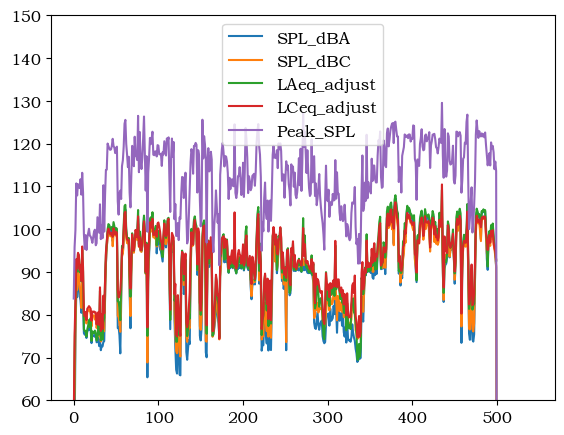

In [67]:
fig, ax = plt.subplots(1, figsize=(6.5, 5))
i = random.randint(0, len(SPL_dBAs)-1)
logger.info(f"Index: {i}")
ax.plot(SPL_dBAs[i], label="SPL_dBA")
ax.plot(SPL_dBCs[i], label="SPL_dBC")
ax.plot(LAeq_adjusts[i], label="LAeq_adjust")
ax.plot(LCeq_adjusts[i], label="LCeq_adjust")
ax.plot(Peak_SPL_dBs[i], label="Peak_SPL")
ax.set_ylim([60,150])
plt.legend(loc="best")
plt.show()
plt.close(fig=fig)

2024-01-11 11:10:27.432 | INFO     | __main__:<module>:3 - Index: 52


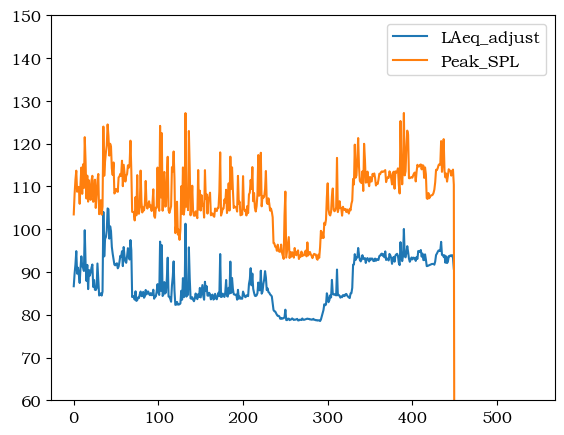

In [68]:
fig, ax = plt.subplots(1, figsize=(6.5, 5))
i = random.randint(0, len(SPL_dBAs)-1)
logger.info(f"Index: {i}")
ax.plot(LAeq_adjusts[i], label="LAeq_adjust")
ax.plot(Peak_SPL_dBs[i], label="Peak_SPL")
ax2 = ax.twinx
ax.set_ylim([60,150])
plt.legend(loc="best")
plt.show()
plt.close(fig=fig)